In [1]:
# Install necessary packages
!pip install -U ultralytics
!pip install wandb==0.16.5
!wandb disabled
!pip install -q kaggle
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Traceback (most recent call last):
  File "/usr/local/bin/wandb", line 5, in <module>
    from wandb.cli.cli import cli
  File "/usr/local/lib/python3.11/dist-packages/wandb/__init__.py", line 27, in <module>
    from wandb import sdk as wandb_sdk
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/__init__.py", line 25, in <module>
    from .artifacts.artifact import Artifact
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/artifacts/artifact.py", line 45, in <module>
    from wandb import data_types, env, util
  File "/usr/local/lib/python3.11/dist-packages/wandb/data_types.py", line 32, in <module>
    from .sdk.data_types import _dtypes
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/_dtypes.py", line 393, in <module>
    NumberType.types.append(np.float_)
                            ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/__init__.py", line 397, in __getattr__
    raise AttributeError(
AttributeError: `np.float_` was remo

In [4]:
from google.colab import files
files.upload()  # upload kaggle.json manually
!mkdir -p ~/.kaggle
# Rename and move your uploaded file
!mv "/content/kaggle (2).json" ~/.kaggle/kaggle.json
# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json
# Download pest dataset from Kaggle
!kaggle datasets download -d simranvolunesia/pest-dataset
# Unzip the dataset
!unzip -q pest-dataset.zip -d /content/dataset

Saving archive (1).zip to archive (1) (1).zip
Dataset URL: https://www.kaggle.com/datasets/simranvolunesia/pest-dataset
License(s): CC0-1.0
 73% 51.0M/69.5M [00:00<00:00, 528MB/s]
100% 69.5M/69.5M [00:00<00:00, 266MB/s]


In [5]:
import os

train_path = "/content/dataset/pest/train"
test_path = "/content/dataset/pest/test"

print("Train folders:", os.listdir(train_path))
print("Test folders:", os.listdir(test_path))


Train folders: ['mites', 'armyworm', 'bollworm', 'grasshopper', 'beetle', 'sawfly', 'stem_borer', 'mosquito', 'aphids']
Test folders: ['mites', 'armyworm', 'bollworm', 'grasshopper', 'beetle', 'sawfly', 'stem_borer', 'mosquito', 'aphids']


In [6]:
def get_data_info(path):
    classes = os.listdir(path)
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            print(f"{class_name}: {count} images")
    return class_counts

train_dist = get_data_info(train_path)
test_dist = get_data_info(test_path)


mites: 300 images
armyworm: 300 images
bollworm: 300 images
grasshopper: 300 images
beetle: 300 images
sawfly: 300 images
stem_borer: 300 images
mosquito: 300 images
aphids: 300 images
mites: 50 images
armyworm: 50 images
bollworm: 50 images
grasshopper: 50 images
beetle: 50 images
sawfly: 50 images
stem_borer: 50 images
mosquito: 50 images
aphids: 50 images


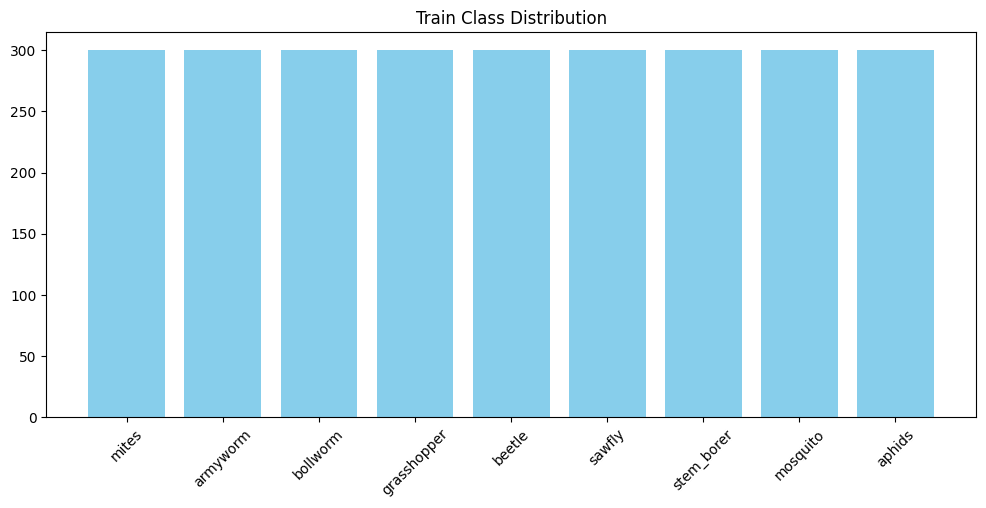

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(train_dist.keys(), train_dist.values(), color='skyblue')
plt.title('Train Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2160 images belonging to 9 classes.
Found 540 images belonging to 9 classes.


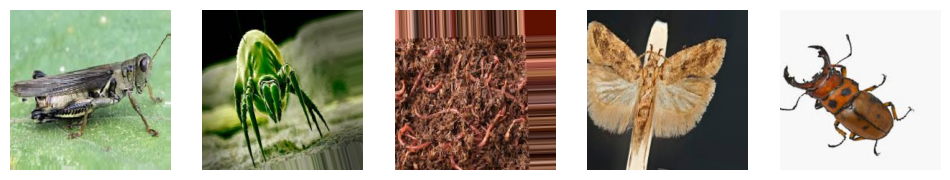

In [9]:
import numpy as np

def show_augmented_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_augmented_images(train_generator)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_path = "/content/dataset/pest/train"

# Train generator
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = datagen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2160 images belonging to 9 classes.
Found 540 images belonging to 9 classes.


In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,121 (42.61 MB)

 Trainable params: 11,170,121 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1367 - loss: 2.3912

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.1367 - loss: 2.3891 - val_accuracy: 0.1759 - val_loss: 2.1802
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.1824 - loss: 2.1736 - val_accuracy: 0.2333 - val_loss: 2.1538
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.2096 - loss: 2.1210 - val_accuracy: 0.1796 - val_loss: 2.1216
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.2277 - loss: 2.0916 - val_accuracy: 0.2426 - val_loss: 2.0539
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.2442 - loss: 2.0157 - val_accuracy: 0.2611 - val_loss: 1.9929
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.2818 - loss: 1.9044 - val_accuracy: 0.2796 - val_loss: 2.0027
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.2972 - loss: 1.8666 - val_accuracy: 0.3056 - val_loss: 1.9398
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.3370 - loss: 1.8277 - val_accuracy: 0.3259 - val_loss: 1.

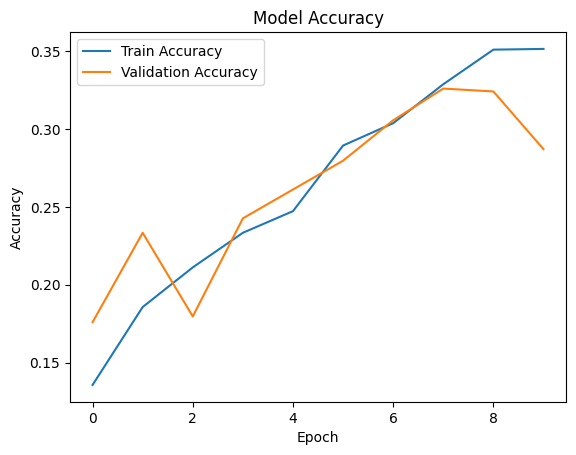

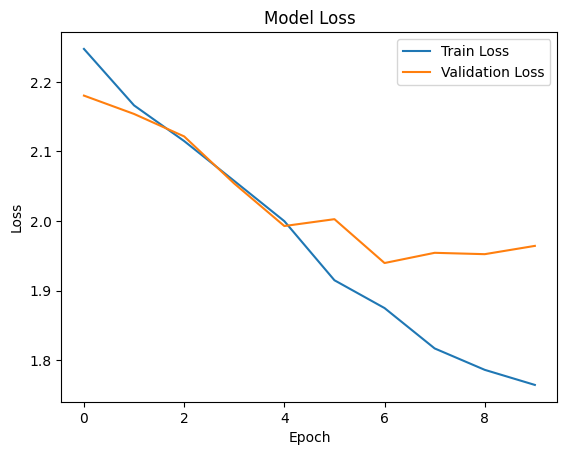

In [14]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [15]:
model.save("pest_detector_cnn.h5")
print("Model saved as pest_detector_cnn.h5")


Model saved as pest_detector_cnn.h5


# **Load and Preprocess Test Data**

In [17]:
# Reuse same image size and preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

test_path = "/content/dataset/pest/test"

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for predictions and metrics
)


Found 450 images belonging to 9 classes.


# **Evaluate on Test Set**

In [18]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Test Loss: {loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 877ms/step - accuracy: 0.4431 - loss: 1.5986
✅ Test Accuracy: 45.33%
📉 Test Loss: 1.6151


# **Load and Predict One Image**

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load one image from test folder
sample_image_path = test_generator.filepaths[0]
img = image.load_img(sample_image_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_labels = list(test_generator.class_indices.keys())

print(f"📸 Image Path: {sample_image_path}")
print(f"🧠 Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
📸 Image Path: /content/dataset/pest/test/aphids/jpg_0 - Copy.jpg
🧠 Predicted Class: aphids


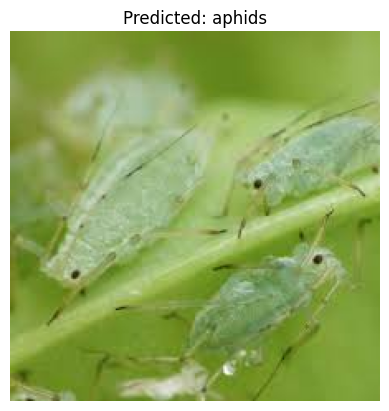

In [20]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.show()


# **Get True & Predicted Labels**

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 880ms/step


# **Classification Report**

In [22]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print("📝 Classification Report:\n")
print(report)


📝 Classification Report:

              precision    recall  f1-score   support

      aphids       0.48      0.50      0.49        50
    armyworm       0.53      0.16      0.25        50
      beetle       0.62      0.68      0.65        50
    bollworm       0.50      0.44      0.47        50
 grasshopper       0.27      0.34      0.30        50
       mites       0.40      0.42      0.41        50
    mosquito       0.66      0.84      0.74        50
      sawfly       0.33      0.56      0.41        50
  stem_borer       0.37      0.14      0.20        50

    accuracy                           0.45       450
   macro avg       0.46      0.45      0.44       450
weighted avg       0.46      0.45      0.44       450



# **Confusion Matrix**

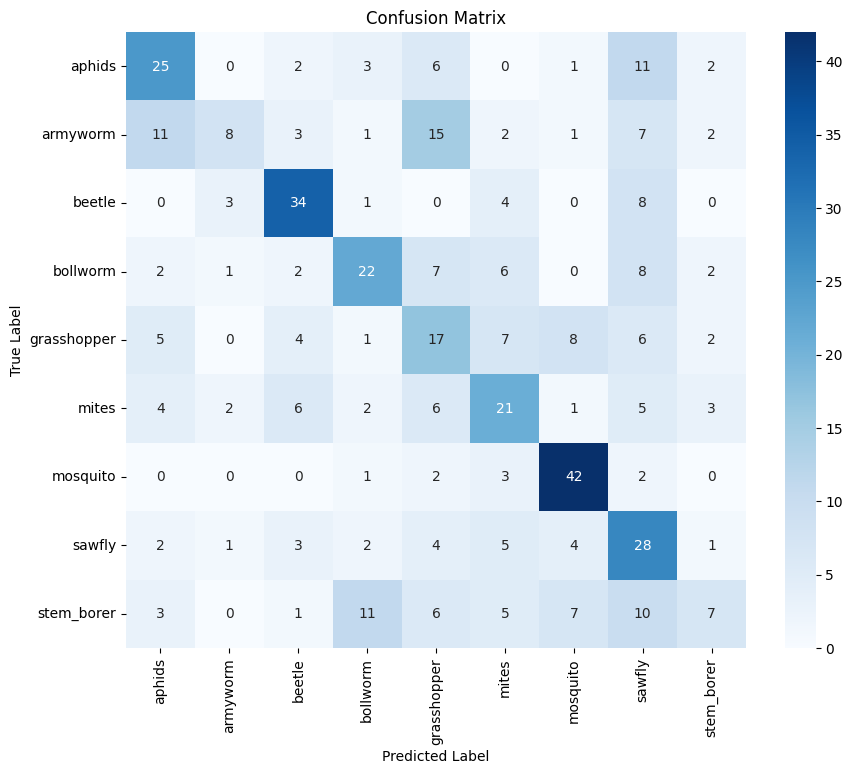

In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **Predict a Batch of Test Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


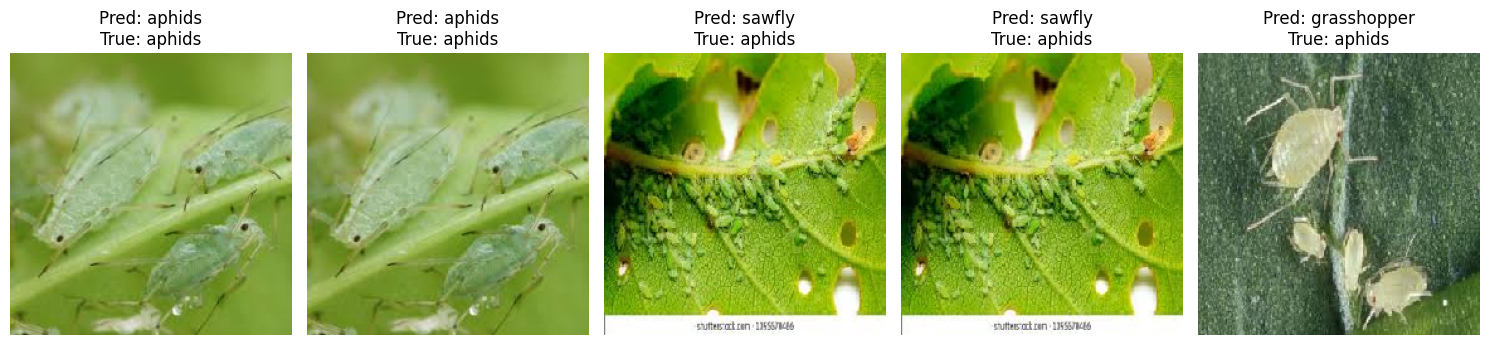

In [24]:
# Get a batch of images and labels
images, labels = next(test_generator)

# Predict
preds = model.predict(images)
predicted_indices = np.argmax(preds, axis=1)
true_indices = np.argmax(labels, axis=1)

# Display 5 images with predictions
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_labels[predicted_indices[i]]}\nTrue: {class_labels[true_indices[i]]}")
plt.tight_layout()
plt.show()


# **Final Gradio Web App (Pest Detection + Advisory)**

In [25]:
!pip install gradio tensorflow

In [26]:
# Sample advisory dictionary (you should customize this)
pest_advisory = {
    "Whitefly": "Use yellow sticky traps, neem oil spray (3 ml/l), and release natural predators like Encarsia.",
    "Aphid": "Spray neem oil (5 ml/l) or Imidacloprid 0.3 ml/l. Maintain weed-free fields.",
    "Jassid": "Use Thiamethoxam (0.3 g/l) or Neem-based sprays. Avoid overwatering.",
    "Thrips": "Apply Spinosad (0.3 ml/l) or Verticillium lecanii. Keep plant surroundings clean.",
    "Mealybug": "Spray 70% alcohol + neem oil mix. Introduce ladybugs as biological control.",
    "Mite": "Use acaricides like Fenpyroximate or spray soap + neem mix every 3 days."
}


In [27]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2

# Load the trained model
model = load_model("pest_detector_cnn.h5")

# Class labels (must match your model training order)
class_labels = list(pest_advisory.keys())

def predict_and_advise(img):
    # Resize and normalize
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    # Predict
    preds = model.predict(img_array)
    pred_class = class_labels[np.argmax(preds)]

    # Fetch advisory
    remedy = pest_advisory.get(pred_class, "No advisory available for this pest.")

    return f"🦠 Predicted Pest: {pred_class}\n🩺 Cure/Advisory: {remedy}"


In [30]:
gr.Interface(
    fn=predict_and_advise,
    inputs=gr.Image(type="numpy", label="Upload Pest-Infected Leaf"),
    outputs=gr.Textbox(label="Diagnosis & Treatment"),
    title="🪰 Cotton Pest Detector & Advisory",
    description="Upload an image of a cotton plant infected with pests. The model will identify the pest and provide a treatment advisory."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dcd4cad9f06ee675c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
